# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# simulation output folder
experiment_name = 'explore_demand_1'

# load Java simulation data
experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]

                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

### 1. Select demand scenarios

In [5]:
# select merging lanes and required FD variables
variables = ['BC.LEFT_density', 'BC.LEFT_flow', 
             'BC.RIGHT_density', 'BC.RIGHT_flow', 
             'BC.ONRAMP_density', 'BC.ONRAMP_flow',
             'E2B.ONRAMP_density', 'E2B.ONRAMP_flow']

In [6]:
# get intermediate FD data
df_fd = load_dataframe(variables, experiment_folder, intermediate_output, input_values)
# add time column, each FD calculation represents 30 sec
df_fd['time'] = df_fd.groupby(['seed', 'run']).cumcount() * 30
# select columns of interest
variables_of_interest = ['time', 'seed', 'run', 'main_demand', 'ramp_demand'] + variables
columns_to_include = [col for col in df_fd.columns if col in variables_of_interest]
df_fd = df_fd[columns_to_include]

In [7]:
# show scatter plot
def show_fd_scatter_plot(df, density_var, flow_var):
    plt.figure(figsize=(12,8))
    plt.scatter(df[density_var], df[flow_var])
    plt.xlabel('Density [veh/km]')
    plt.ylabel('Flow [veh/h]')
    plt.title('Fundamental diagram data points')
    plt.show()


# convert data
def convert_fd_data(df):
    df_converted = df.copy()
    for col in df_converted.columns.tolist():
        if 'flow' in col:
            df_converted[col] = df_converted[col].astype(float) * 3600
        if 'density' in col:
            df_converted[col] = df_converted[col].astype(float) * 1000
        if 'speed' in col:
            df_converted[col] = df_converted[col].astype(float) * 3.6
    return df_converted


# set box limits to filter FD values
def remove_fd_non_compliant_runs(df, density_column, flow_density, min_density_value, max_density_value, min_flow_value, max_flow_value):
    # identify runs with any data points outside the box
    non_compliant_runs = df[
        (df[density_column] <= min_density_value) | 
        (df[density_column] >= max_density_value) | 
        (df[flow_density] <= min_flow_value) | 
        (df[flow_density] >= max_flow_value)
        ][['seed', 'run']].drop_duplicates()

    # filter out these non-compliant runs from the main DataFrame
    df_filtered = df.merge(non_compliant_runs, on=['seed', 'run'], how='left', indicator=True)
    df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    # return new DataFrame
    return df_filtered


# set box limits to filter FD values
def remove_demand_non_compliant_runs(df, min_main_value, max_main_value, min_ramp_value, max_ramp_value):
    # identify runs with any data points outside the box
    non_compliant_runs = df[
        (df['main_demand'] <= min_main_value) | 
        (df['main_demand'] >= max_main_value) | 
        (df['ramp_demand'] <= min_ramp_value) | 
        (df['ramp_demand'] >= max_ramp_value)
        ][['seed', 'run']].drop_duplicates()

    # filter out these non-compliant runs from the main DataFrame
    df_filtered = df.merge(non_compliant_runs, on=['seed', 'run'], how='left', indicator=True)
    df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    # return new DataFrame
    return df_filtered

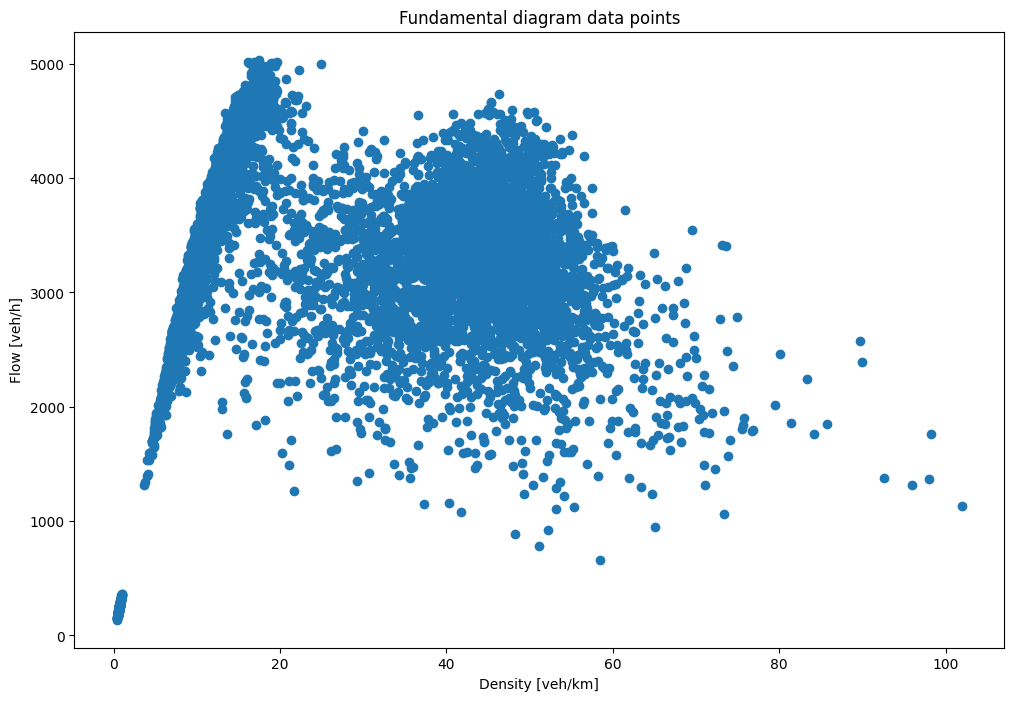

In [8]:
# combine road areas
df_fd_combined = pd.DataFrame()
df_fd_combined['time'] = df_fd['time']
df_fd_combined['main_demand'] = df_fd['main_demand']
df_fd_combined['ramp_demand'] = df_fd['ramp_demand']
df_fd_combined['BC_flow'] = df_fd['BC.LEFT_flow'] + df_fd['BC.RIGHT_flow'] + df_fd['BC.ONRAMP_flow']
df_fd_combined['BC_density'] = (df_fd['BC.LEFT_density'] + df_fd['BC.RIGHT_density'] + df_fd['BC.ONRAMP_density']) / 3
df_fd_combined['E2B.ONRAMP_flow'] = df_fd['E2B.ONRAMP_flow']
df_fd_combined['E2B.ONRAMP_density'] = df_fd['E2B.ONRAMP_density']
    
df_new_fd = convert_fd_data(df_fd_combined)
show_fd_scatter_plot(df_new_fd, 'BC_density', 'BC_flow')

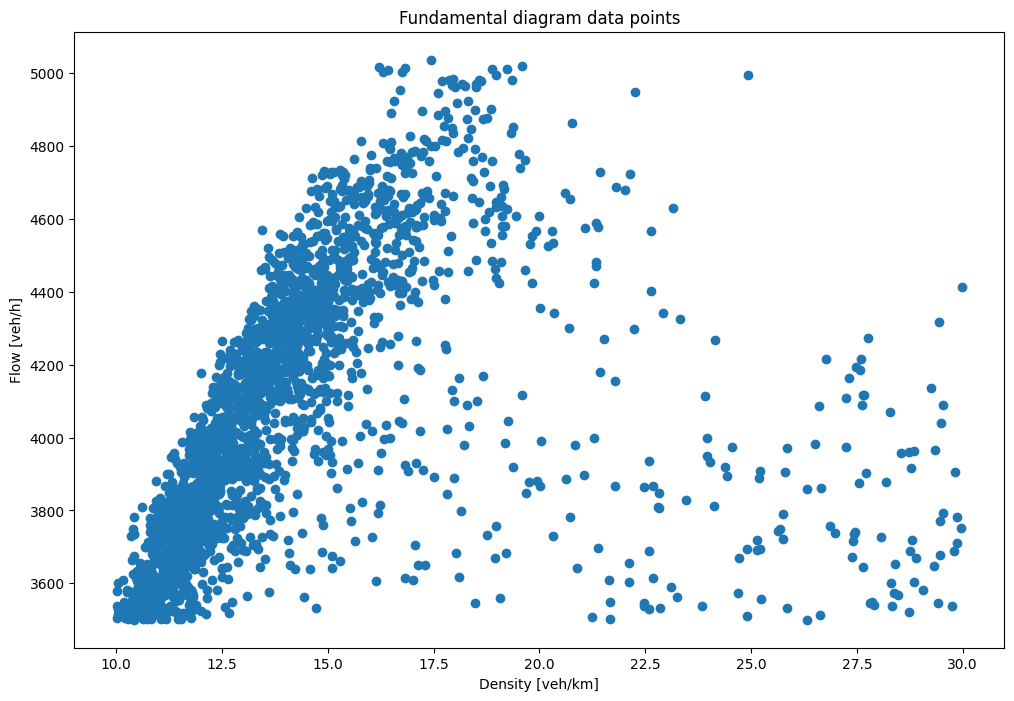

In [9]:
# select box of data points
min_density = 10
max_density = 30
min_flow = 3500
max_flow = 6000
density_column = 'BC_density'
flow_column = 'BC_flow'
df_new_fd_box = remove_fd_non_compliant_runs(df_new_fd, density_column, flow_column,
                                          min_density, max_density, min_flow, max_flow)

# show scatter plot for this box
show_fd_scatter_plot(df_new_fd_box, 'BC_density', 'BC_flow')

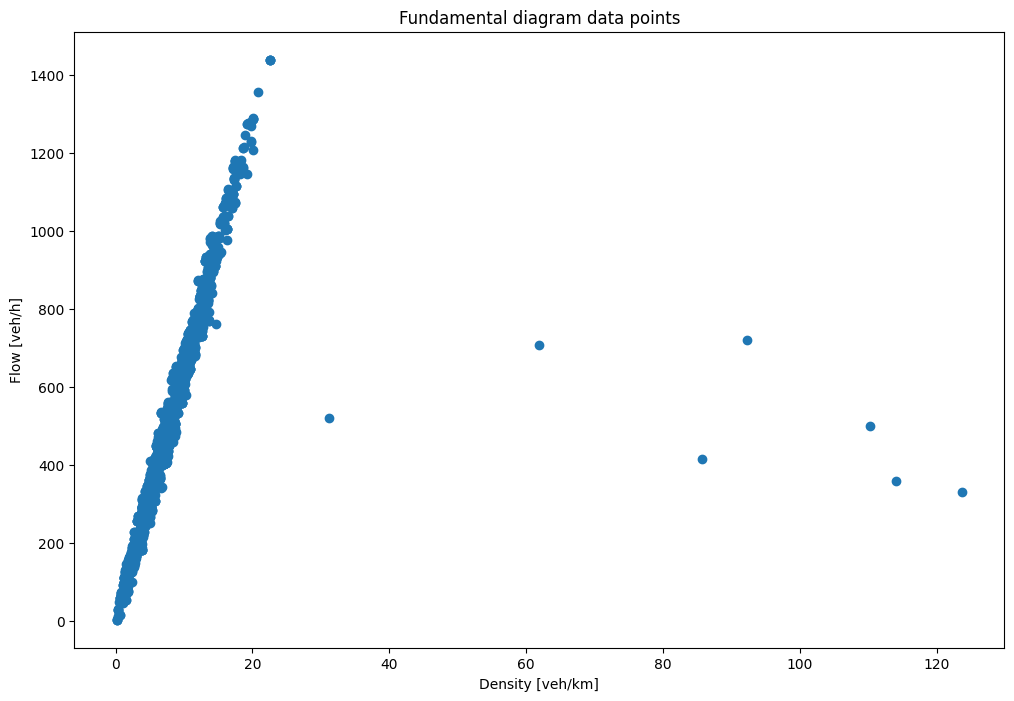

In [10]:
# show Fd values for on-ramp lane
show_fd_scatter_plot(df_new_fd_box, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

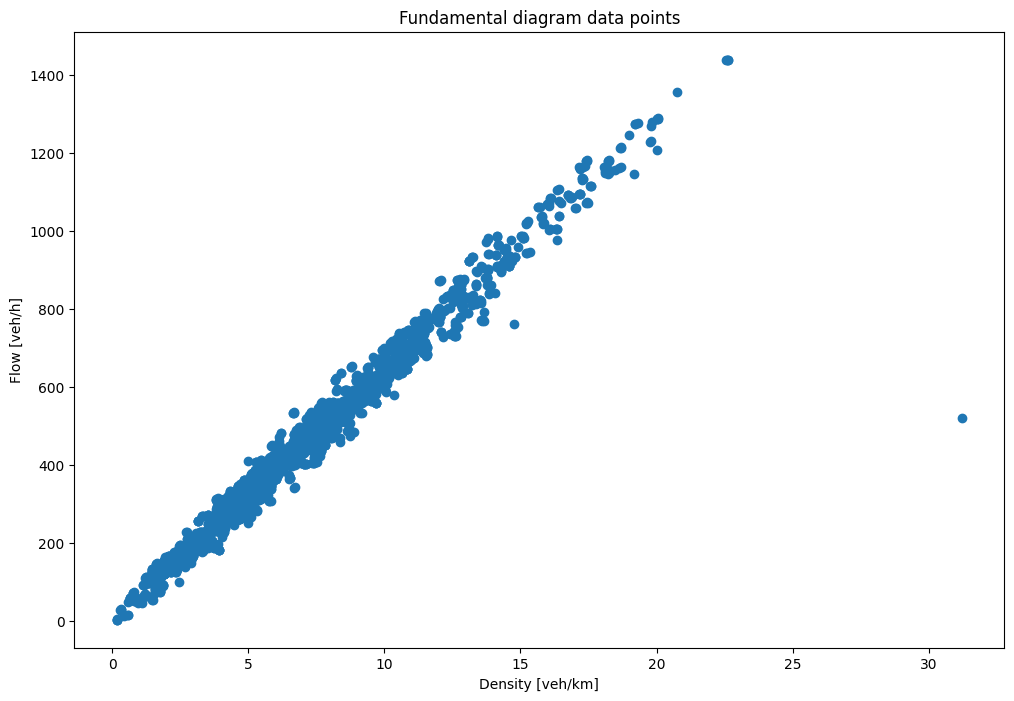

In [11]:
# select box of data points
min_density = 0
max_density = 40
min_flow = 0
max_flow = 2000
density_column = 'E2B.ONRAMP_density'
flow_column = 'E2B.ONRAMP_flow'
df_new_fd_box2 = remove_fd_non_compliant_runs(df_new_fd_box, density_column, flow_column,
                                           min_density, max_density, min_flow, max_flow)

# show Fd values for on-ramp lane
show_fd_scatter_plot(df_new_fd_box2, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

In [12]:
# get range of demand variables
print("Main demand:", df_new_fd_box['main_demand'].min(), " - ", df_new_fd_box['main_demand'].max())
print("Ramp demand", df_new_fd_box['ramp_demand'].min(), " - ", df_new_fd_box['ramp_demand'].max())

Main demand: 2000.6785817806056  -  3995.1174291587
Ramp demand 207.05198283883647  -  799.481243307799


Merge lanes data:


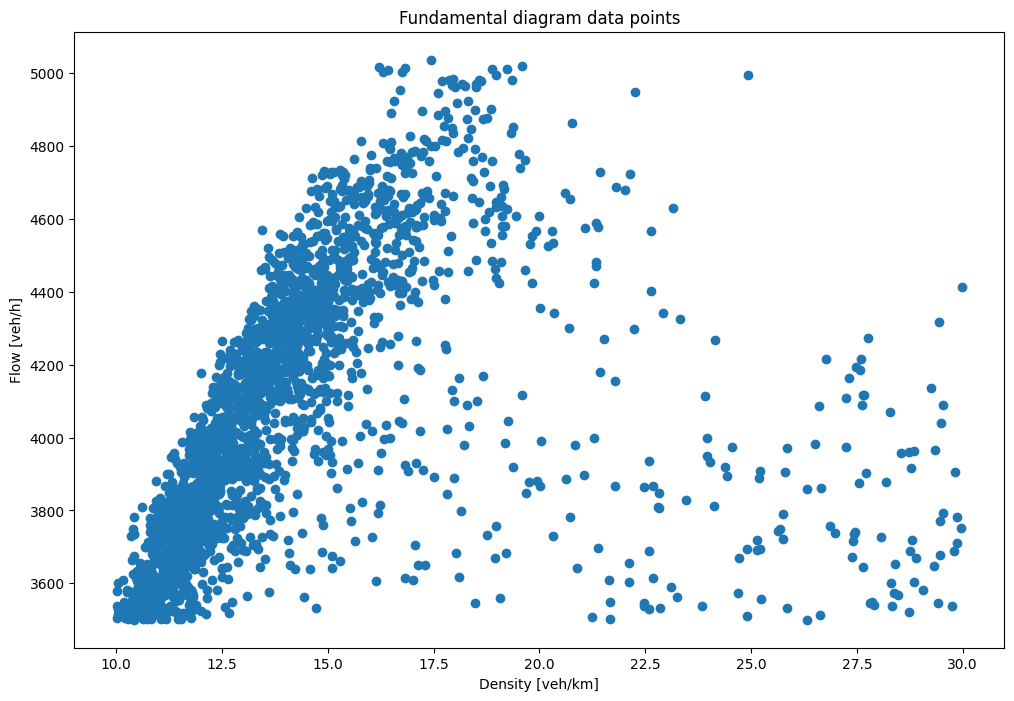

On-ramp data:


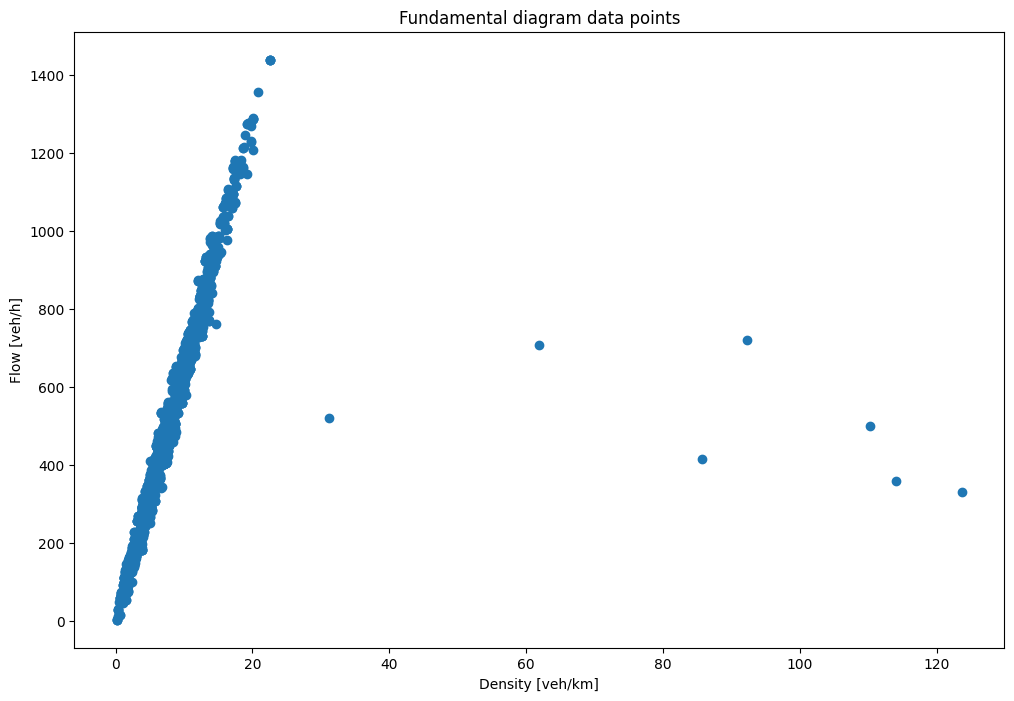

In [13]:
# show original data filtered for demand values
min_main = 2000
max_main = 4000
min_ramp = 100
max_ramp = 800
df_demand_box = remove_demand_non_compliant_runs(df_new_fd, min_main, max_main, min_ramp, max_ramp)

# show refined scatter plot
print('Merge lanes data:')
show_fd_scatter_plot(df_new_fd_box_r, 'BC_density', 'BC_flow')
print('On-ramp data:')
show_fd_scatter_plot(df_new_fd_box_r, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

### Conclusions
Demand...